# Nombre de la asignatura: Mineria de datos
### Carrera: Big Data
### Estudiante: Paul Rodriguez, Carlos Astudillo, Ariel Saquicela
### Fecha:22/04/2024

### Objetivos de la Práctica:
En la siguiente práctica se realizará el proceso de Extracción, Transformación y Carga de Datos.

En primera instancia se debe de crear la estructura de la base de datos para ello se adjunta el script de la base de datos. En mysql cuyo nombre es: Dump20240109.ssql


### 1. Importamos las librerías

Si no tiene instalado la librería mysql.connector debe de ejecutar la siguiente línea de comandos.

In [46]:
# pip install mysql.connector

In [47]:
#!pip install mysql.connector

In [48]:
#!pip install xlrd

In [78]:
#!pip install pymysql

In [1]:
import mysql.connector
import pandas as pd

### 2. Cargamos la data

In [4]:
# Especifica la ruta de tu archivo Excel
ruta_archivo_excel = "Datos_Taxis.xls"

# Lee el archivo Excel y conviértelo a un DataFrame
df = pd.read_excel(ruta_archivo_excel)

# Muestra las primeras filas del DataFrame
df.head()


,Placa,Clase,Marca,Año de fabricación del taxi,Categoría,Tipo taxi
0,AP-000024,Taxi Aeropuerto,Toyota,1990,Automovil,Sedan
1,AP-000033,Taxi Aeropuerto,Nissan,1990,Automovil,Sedan
2,AP-000035,Taxi Aeropuerto,Nissan,1990,Automovil,Sedan
3,AP-000049,Taxi Aeropuerto,Volvo,1990,Automovil,Sedan
4,AP-000074,Taxi Aeropuerto,Nissan,1990,Automovil,Sedan


### 3. Proceso de extracción y Carga de Datos

### 3.1. Conexión a la base de datos

Para esta sección debe de ejecutar o importar el script de la base de datos.

In [8]:
#Método para conectar a la base de datos
def establecer_conexion(host, user, password, database):
    try:
        conexion = mysql.connector.connect(
            host="localhost",
            user="root",
            password="",
            database="taxis"
        )
        return conexion
    except mysql.connector.Error as err:
        print(f"Error: {err}")
        return None

In [10]:
conexion = establecer_conexion("localhost", "root", "", "taxis")
#Comprobación de la conexión
conexion.is_connected()

True

### 3.2. Eliminar los datos de la base de datos

In [13]:
# Datos antes de eliminarlos

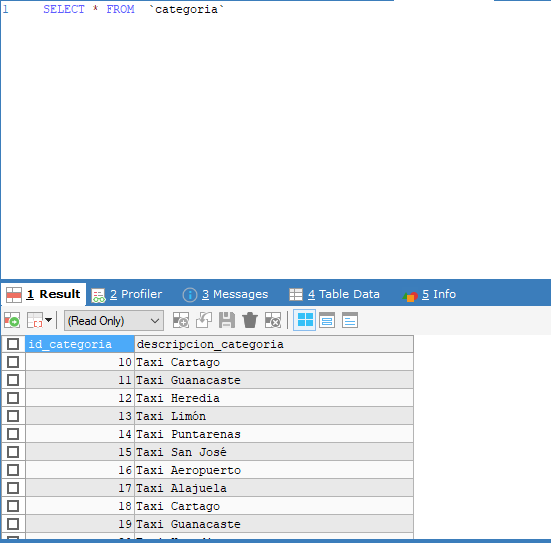

In [15]:
from IPython.display import Image
Image(filename='datos.png')


In [17]:
def eliminar_datos_base(conexion):
    try:
        # Desactivar las restricciones de clave externa para permitir la eliminación
        cursor = conexion.cursor()
        cursor.execute("SET FOREIGN_KEY_CHECKS=0;")

        # Eliminar datos de las tablas
        delete_queries = [
            'DELETE FROM clase;',
            'DELETE FROM marca;',
            'DELETE FROM taxi;',
            'DELETE FROM categoria;',
            'DELETE FROM tipo_taxi;',
            'DELETE FROM taxi_stg;'
        ]

        for query in delete_queries:
            cursor.execute(query)

        # Reiniciar los contadores de autoincremento
        reset_auto_increment_queries = [
            'ALTER TABLE clase AUTO_INCREMENT = 1;',
            'ALTER TABLE marca AUTO_INCREMENT = 1;',
            'ALTER TABLE marca AUTO_INCREMENT = 1;',
            'ALTER TABLE categoria AUTO_INCREMENT = 1;',
            'ALTER TABLE tipo_taxi AUTO_INCREMENT = 1;',
            'ALTER TABLE taxi_stg AUTO_INCREMENT = 1;'
        ]

        for query in reset_auto_increment_queries:
            cursor.execute(query)

        # Confirmar los cambios
        conexion.commit()

        print("Base de datos limpiada exitosamente.")

    except Exception as e:
        print(f"Error al limpiar la base de datos: {e}")

    finally:
        # Reactivar las restricciones de clave externa
        cursor.execute("SET FOREIGN_KEY_CHECKS=1;")
        cursor.close()


In [19]:
eliminar_datos_base(conexion)

Base de datos limpiada exitosamente.


In [21]:
# Datos eliminados

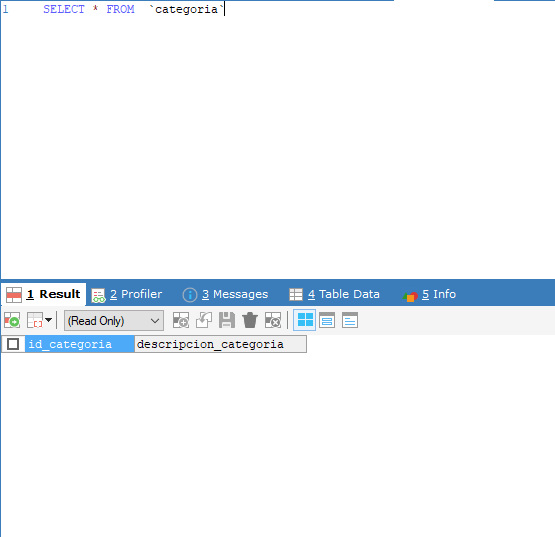

In [23]:
from IPython.display import Image
Image(filename='datos_l.png')

### 3.3. Insertar datos a la tabla taxi

In [26]:
  
def insert_taxi_stg(conexion, df):
    cursor = conexion.cursor()

    insert_query = "INSERT INTO taxi_stg(placa,clase,marca, ano_fabricacion,categoria,tipo_taxi) VALUES (%s, %s, %s, %s, %s, %s)"

    try:
        for index, row in df.iterrows():
            taxi_data = (row['Placa'], row['Clase'], row['Marca'], row['Año de fabricación del taxi'], row['Categoría'], row['Tipo taxi'])
            cursor.execute(insert_query, taxi_data)

        conexion.commit()
        print(f"Datos insertados correctamente")

    except Exception as e:
        print(f"Error al insertar datos: {e}")

    finally:
        cursor.close()

In [28]:
insert_taxi_stg(conexion, df)

Datos insertados correctamente


In [29]:
# Imagen de los datos insertados

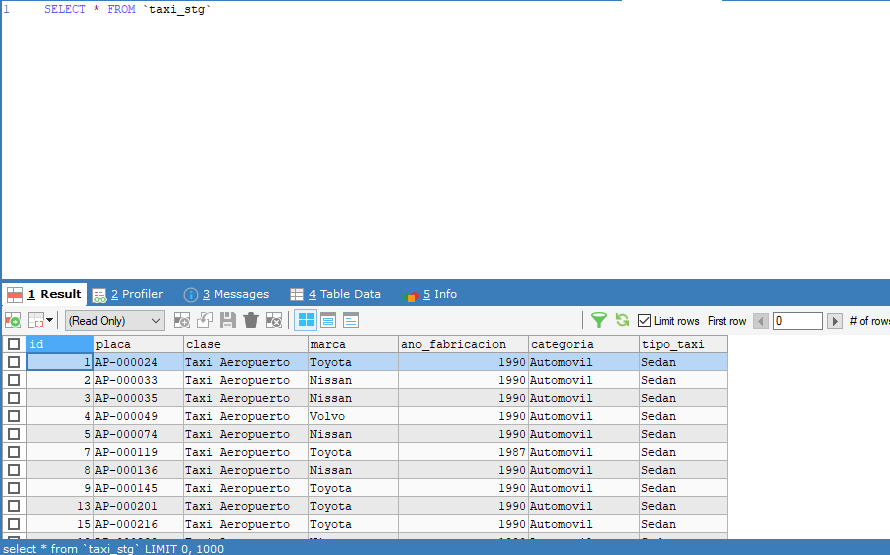

In [30]:
from IPython.display import Image
Image(filename='datos_t.png')


### 3.4. Limpiar datos innecesarios

In [35]:
def limpiar_datos_taxi_stg(conexion):
    try:
        # Desactivar las restricciones de clave externa para permitir la eliminación
        cursor = conexion.cursor()
        cursor.execute("SET FOREIGN_KEY_CHECKS=0;")

        # Eliminar datos de las tablas
        delete_queries = [
            'delete from taxi_stg where ano_fabricacion=0;',
            'delete from taxi_stg where marca like"%Marca%no%registrada%";',
            'delete from taxi_stg where categoria like"%Categoria%no%registrada%";',
            'delete from taxi_stg where tipo_taxi="Noid"'        
        ]

        for query in delete_queries:
            cursor.execute(query)

        # Confirmar los cambios
        conexion.commit()

        print("Datos tabla taxi stg limpiada exitosamente.")

    except Exception as e:
        print(f"Error al limpiar la base de datos: {e}")

    finally:
        # Reactivar las restricciones de clave externa
        cursor.execute("SET FOREIGN_KEY_CHECKS=1;")
        cursor.close()


In [37]:
limpiar_datos_taxi_stg(conexion)

Datos tabla taxi stg limpiada exitosamente.


In [39]:
#Resultado de la limpieza 

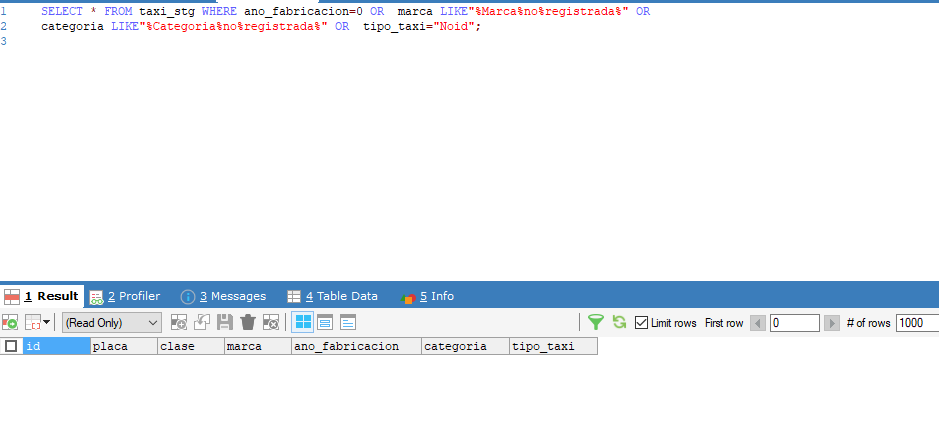

In [41]:
from IPython.display import Image
Image(filename='datos_t_stg_a.png')

### 3.4. Obtener valores distintos y asignar a las respectivas tablas

In [44]:
def obtener_distinct_values(conexion, column_name):
    try:
        cursor = conexion.cursor()
        select_query = f"SELECT DISTINCT({column_name}) FROM taxi_stg"
        cursor.execute(select_query)
        distinct_values = cursor.fetchall()
        print(f"Datos extraidos correctamente de: {column_name}")
        return tuple(value[0] for value in distinct_values)
    except Exception as e:
        print(f"Error al obtener valores distintos: {e}")
        return []
    finally:
        if cursor:
            cursor.close()


In [46]:
distinct_values_categorias=obtener_distinct_values(conexion, "categoria")
distinct_values_categorias

Datos extraidos correctamente de: categoria


('Automovil',
 'Microbus',
 'Carga liviana',
 'Taxi',
 'Autobus',
 'Taxi ( transporte de discapacitados )',
 'Transporte colectivo interurbano')

In [48]:
distinct_values_tipo_taxi=obtener_distinct_values(conexion, "tipo_taxi")
distinct_values_tipo_taxi

Datos extraidos correctamente de: tipo_taxi


('Sedan', 'Microbus', 'Rural', 'Adaptado')

In [50]:
distinct_values_clases=obtener_distinct_values(conexion, "clase")
distinct_values_clases

Datos extraidos correctamente de: clase


('Taxi Aeropuerto',
 'Taxi Alajuela',
 'Taxi Cartago',
 'Taxi Guanacaste',
 'Taxi Heredia',
 'Taxi Limón',
 'Taxi Puntarenas',
 'Taxi San José')

In [52]:
distinct_values_marcas=obtener_distinct_values(conexion, "marca")
distinct_values_marcas

Datos extraidos correctamente de: marca


('Toyota',
 'Nissan',
 'Volvo',
 'Citroen',
 'Hyundai',
 'Peugeot',
 'Daihatsu',
 'Mitsubishi',
 'Kia',
 'Faw',
 'Suzuki',
 'Isuzu',
 'Greatwall',
 'Ssang yong',
 'Ford',
 'Mazda',
 'Lifan',
 'Jac',
 'Fiat',
 'Geely',
 'Dfm',
 'Chevrolet',
 'Mahindra',
 'Gonow',
 'Renault',
 'Golden dragon',
 'Baw',
 'Jmc',
 'South east',
 'Daewoo',
 'Changan',
 'Geo',
 'Foton',
 'Tianma',
 'Dongfeng',
 'Zna',
 'Zotye',
 'Land rover',
 'Cmc',
 'Volkswagen',
 'Honda',
 'Byd',
 'Dacia',
 'Dodge',
 'Asia',
 'Changhe')

### 3.5. Insertar los datos extraidos en las respectivas tablas

In [55]:
def insert_distinct_values_into_table(conexion, distinct_values, table_name, column_name):
    try:
        cursor = conexion.cursor()
        insert_query = f"INSERT INTO {table_name} ({column_name}) VALUES (%s)"
        for value in distinct_values:
            cursor.execute(insert_query, (value,))

        conexion.commit()
        print(f"Datos insertados correctamente en {table_name}.")

    except Exception as e:
        print(f"Error al insertar datos en {table_name}: {e}")
    finally:
        if cursor:
            cursor.close()

insert_distinct_values_into_table(conexion, distinct_values_marcas, "marca", "descripcion_marca")


Datos insertados correctamente en marca.


In [56]:
insert_distinct_values_into_table(conexion, distinct_values_marcas, "marca", "descripcion_marca")

Datos insertados correctamente en marca.


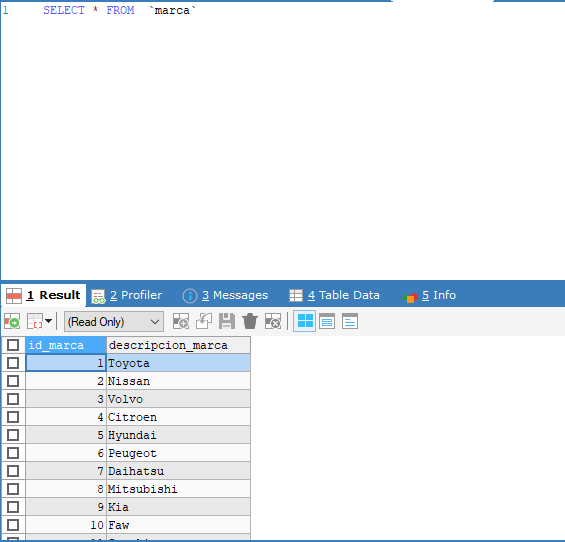

In [9]:
from IPython.display import Image
Image(filename='datos_m.png')

In [61]:
insert_distinct_values_into_table(conexion, distinct_values_clases, "clase", "descripcion_clase")

Datos insertados correctamente en clase.


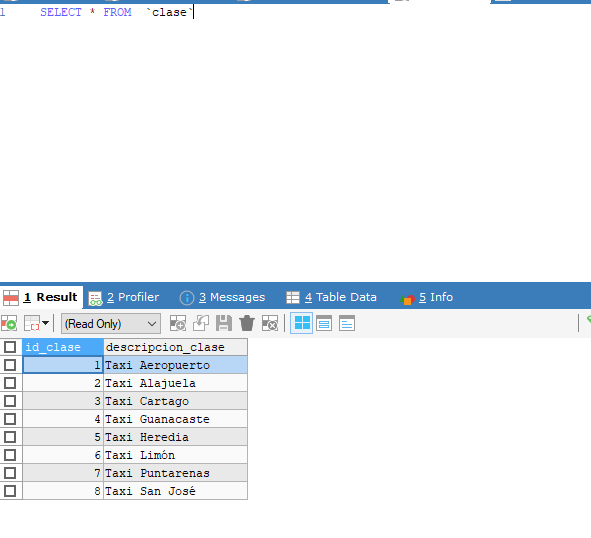

In [63]:
from IPython.display import Image
Image(filename='datos_c.png')

In [65]:
insert_distinct_values_into_table(conexion, distinct_values_categorias, "categoria", "descripcion_categoria")

Datos insertados correctamente en categoria.


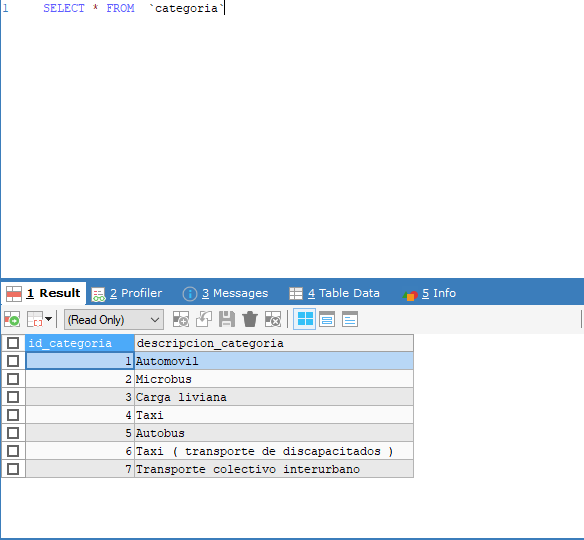

In [67]:
from IPython.display import Image
Image(filename='datos_ca.png')

In [69]:
insert_distinct_values_into_table(conexion, distinct_values_tipo_taxi, "tipo_taxi", "descripcion_tipo_taxi")

Datos insertados correctamente en tipo_taxi.


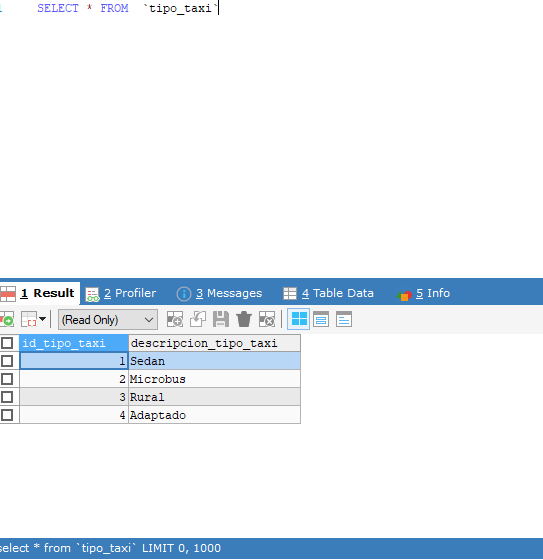

In [71]:
from IPython.display import Image
Image(filename='datos_tipo_t.png')

### 3.6. Obtener los valores relacionados con su respectivo ID

In [80]:
import pymysql

def obtener_valores_taxi(conexion):
    try:
        cursor = conexion.cursor()
        select_query = '''
        SELECT taxi_stg.placa, clase.id_clase, marca.id_marca, taxi_stg.ano_fabricacion, categoria.id_categoria, tipo_taxi.id_tipo_taxi 
        FROM taxi_stg
        INNER JOIN clase ON taxi_stg.clase = clase.descripcion_clase
        INNER JOIN marca ON taxi_stg.marca = marca.descripcion_marca
        INNER JOIN categoria ON taxi_stg.categoria = categoria.descripcion_categoria
        INNER JOIN tipo_taxi ON taxi_stg.tipo_taxi = tipo_taxi.descripcion_tipo_taxi;
        '''
        cursor.execute(select_query)
        values = cursor.fetchall()
        cursor.close()  # Cierra el cursor después de obtener los valores
        return tuple(values)

    except Exception as e:
        print(f"Error al obtener valores distintos: {e}")
        return []


In [90]:
valores=obtener_valores_taxi(conexion)
valores


(('AP-000024', 1, 1, 1990, 1, 1),
 ('AP-000024', 1, 47, 1990, 1, 1),
 ('AP-000033', 1, 2, 1990, 1, 1),
 ('AP-000033', 1, 48, 1990, 1, 1),
 ('AP-000035', 1, 2, 1990, 1, 1),
 ('AP-000035', 1, 48, 1990, 1, 1),
 ('AP-000049', 1, 3, 1990, 1, 1),
 ('AP-000049', 1, 49, 1990, 1, 1),
 ('AP-000074', 1, 2, 1990, 1, 1),
 ('AP-000074', 1, 48, 1990, 1, 1),
 ('AP-000119', 1, 1, 1987, 1, 1),
 ('AP-000119', 1, 47, 1987, 1, 1),
 ('AP-000136', 1, 2, 1990, 1, 1),
 ('AP-000136', 1, 48, 1990, 1, 1),
 ('AP-000145', 1, 1, 1990, 1, 1),
 ('AP-000145', 1, 47, 1990, 1, 1),
 ('AP-000201', 1, 1, 1990, 1, 1),
 ('AP-000201', 1, 47, 1990, 1, 1),
 ('AP-000216', 1, 1, 1990, 1, 1),
 ('AP-000216', 1, 47, 1990, 1, 1),
 ('AP-000239', 1, 2, 1990, 1, 1),
 ('AP-000239', 1, 48, 1990, 1, 1),
 ('TAP-000002', 1, 1, 2014, 1, 1),
 ('TAP-000002', 1, 47, 2014, 1, 1),
 ('TAP-000003', 1, 1, 2014, 2, 2),
 ('TAP-000003', 1, 47, 2014, 2, 2),
 ('TAP-000004', 1, 1, 2014, 1, 1),
 ('TAP-000004', 1, 47, 2014, 1, 1),
 ('TAP-000005', 1, 2, 2014, 

### 3.7. Insertar los valores en la tabla Taxi

In [ ]:
# Tabla taxi antes de la insercion 

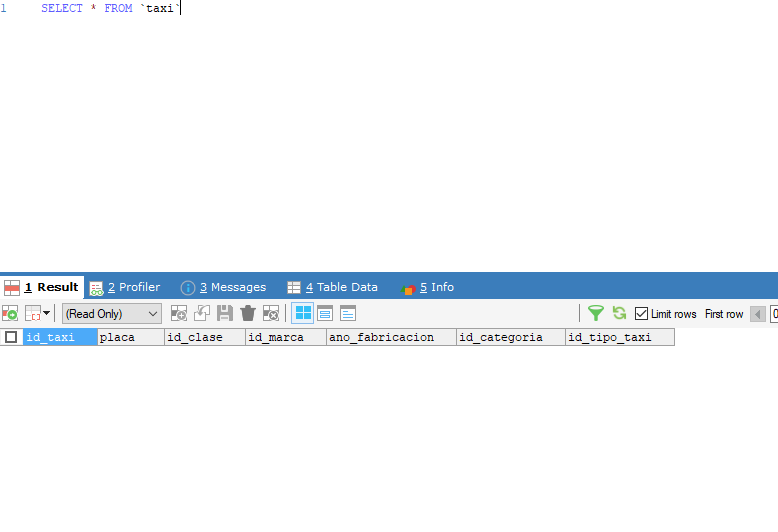

In [97]:
from IPython.display import Image
Image(filename='datos_t_sin_i.png')

In [99]:
def insert_tabla_taxi(conexion, values):
    try:
        cursor = conexion.cursor()
        insert_query = "INSERT INTO taxi (placa, id_clase, id_marca, ano_fabricacion, id_categoria, id_tipo_taxi) VALUES (%s, %s, %s, %s, %s, %s)"

        for value in values:
            cursor.execute(insert_query, value)

        conexion.commit()
        print("Datos insertados correctamente.")

    except Exception as e:
        print(f"Error al insertar datos: {e}")
    
    finally:
        if cursor:
            cursor.close()

def cerrar_conexion(conexion):
    if conexion:
        conexion.close()



In [101]:
insert_tabla_taxi(conexion, valores)

Datos insertados correctamente.


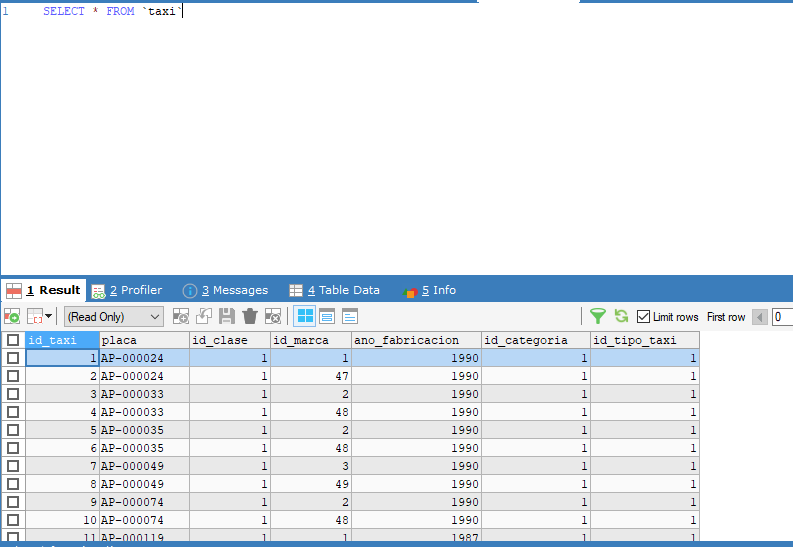

In [103]:
from IPython.display import Image
Image(filename='datos_t_con_i.png')

Comprobar en la base de datos que se hayan insertado los datos correctamente y responder a las siguientes preguntas:

### 1. Diseño de la Base de Datos:

¿Cuál es la estructura de la base de datos utilizada en la práctica? 

Claro, puedo ayudarte a parafrasear la descripción de las tablas y sus relaciones. Aquí está la descripción parafraseada de las tablas y sus relaciones:

1. Tabla "categoria": Esta tabla almacena información sobre diferentes categorías de taxis. Tiene una columna "id_categoria" como clave primaria, que es un identificador único para cada categoría, y una columna "descripcion_categoria" que proporciona la descripción de la categoría.

2. Tabla "clase": Esta tabla tiene información sobre las clases de los taxis. Tiene una columna "id_clase" como clave primaria, que es un identificador único para cada clase, y una columna "descripcion_clase" que describe la clase de taxi.

3. Tabla "marca": En esta tabla se guarda información acerca de las marcas de los taxis. Tiene una columna "id_marca" como clave primaria, que es un identificador único para cada marca, y una columna "descripcion_marca" que proporciona la descripción de la marca.

4. Tabla "taxi": Esta tabla almacena información detallada sobre los taxis, incluyendo la placa, clase, marca, año de fabricación, categoría y tipo de taxi. Tiene una columna "id_taxi" como clave primaria, que es un identificador único para cada taxi. Además, tiene columnas como "placa", "id_clase", "id_marca", "ano_fabricacion", "id_categoria" e "id_tipo_taxi" que son claves foráneas que hacen referencia a las tablas "clase", "marca", "categoria" y "tipo_taxi", respectivamente.

5. Tabla "taxi_stg": Esta tabla es uns tabla de almacenamiento temporal que contiene información similar a la tabla "taxi". Tiene una columna "id" como clave primaria, y las columnas "placa", "clase", "marca", "ano_fabricacion", "categoria" y "tipo_taxi".

6. Tabla "tipo_taxi": Aquí se guarda información sobre los tipos de taxis. Tiene una columna "id_tipo_taxi" como clave primaria, que es un identificador único para cada tipo de taxi, y una columna "descripcion_tipo_taxi" que describe el tipo de taxi.

¿Cómo están relacionadas las tablas entre sí?

Las relaciones entre las tablas se establecen mediante claves foráneas. Esto significa que las columnas en la tabla "taxi" que corresponden a "id_clase", "id_marca", "id_categoria" e "id_tipo_taxi" hacen referencia a los registros en las tablas "clase", "marca", "categoria" y "tipo_taxi", respectivamente, utilizando sus claves primarias. Estas relaciones permiten vincular la información en las tablas y realizar consultas que involucren datos de múltiples tablas.

### 2. Proceso de Extracción y Limpieza:

¿Cómo se realiza la extracción de datos desde el archivo Excel hacia un DataFrame de pandas?

Para extraer datos desde un archivo Excel hacia un DataFrame de pandas, se utilpza la función read_excel()

¿Qué criterios se utilizaron para limpiar los datos innecesarios en la tabla taxi_stg?

Los criterios que se utilizan para limpiar la data stg, son los siguientes, elimina registros donde categoria tenga la frase,categoria sin registrar, elimina en manrca lo que tenga marca no registrada y eliminara el tippo de taxi, que este como Noid


### 3.Inserción de Datos:

¿Cuáles son los pasos específicos para insertar datos en la tabla taxi_stg desde el DataFrame de pandas?

Primero se crea la conexion con la base, en este caso con las librerias mysql.connector y pymysql.
Despues aqui usamos la tabla stg para almacenarlos datos de nuestro exel, se usa sentencias para sacar valores unicos.
Despues usamos el insert para guardar los datos del stg a las tablas de nuestra base.
Cerrar la conexión a la base de datos: No te olvides de cerrar la conexión una vez que hayas terminado de insertar los datos.

¿Cómo se manejan los datos duplicados o los valores inconsistentes durante la inserción?

En este caso se usa el distinc y se usan los valores unicos, eliminamios los datos inconsistentes y intentamos tener claves unicas.

### 4.Obtención y Asignación de Valores Distintos:

¿Cómo se obtienen y asignan los valores distintos de las columnas categoria, tipo_taxi, clase y marca a sus respectivas tablas?
Se utiliza una consulta SQL para obtener los valores distintos de cada columna. Por ejemplo, para obtener los valores distintos de la columna categoria de la tabla taxi_stg

Después de obtener los valores distintos, puedes insertarlos en las tablas categoria, tipo_taxi, clase y marca utilizando instrucciones INSERT. Por ejemplo, para insertar un nuevo valor en la tabla categoria



### 5.Relación de Datos y Carga Final:

¿Cómo se establecen las relaciones entre las tablas taxi_stg, clase, marca, categoria, tipo_taxi y taxi?

Primero se llenan las tablas foraneas y luego se relacionan con la tabla taxi con sus respectivos id

¿Cuál es el proceso final para cargar los datos en la tabla taxi?

unado un iner join una ves tengamos todo lo nesario



# PARTE 2. LECTURA DE DATOS DESDE LA BASE DE DATOS Y VISUALIZACIÓN DE DATOS
### Objetivos:
##### Extraer los datos desde la base de Datos
##### Análisis Exploratorio Efectivo: Enseñar técnicas fundamentales de análisis exploratorio de datos, incluida la identificación y manejo de valores faltantes, así como la exploración de estadísticas descriptivas, para obtener una comprensión inicial de los conjuntos de datos.
##### Visualización Impactante: Introducir conceptos clave de visualización de datos utilizando Matplotlib y Seaborn, y explorar la integración de "PowerClient - Quick Report" para generar visualizaciones impactantes que resalten patrones y tendencias de manera clara y efectiva.

### 1: Importación de librerías

In [98]:
# pip install mysql.connector

In [99]:
import pandas as pd
import mysql.connector
import pandas as pd

### 2: Cargar los datos

In [101]:
def establecer_conexion(host, user, password, database):
    try:
        conexion = mysql.connector.connect(
            host=host,
            user=user,
            password=password,
            database=database
        )
        return conexion
    except mysql.connector.Error as err:
        print(f"Error: {err}")
        return None

            
def obtener_valores_taxi(conexion):
    try:
        with conexion.cursor() as cursor:
            select_query = '''
            SELECT * from taxi_stg;
            '''
            cursor.execute(select_query)
            values = cursor.fetchall()
            return tuple(values)

    except Exception as e:
        print(f"Error al obtener valores distintos: {e}")
        return []

            
def cerrar_conexion(conexion):
    if conexion:
        conexion.close()


In [106]:
conexion = establecer_conexion("localhost", "root", "", "taxis_prueba")
conexion.is_connected()

True

In [ ]:
datos_taxi=obtener_valores_taxi(conexion)

In [ ]:
# Convertir la tupla en un DataFrame
columnas = ['Id','Placa', 'Clase', 'Marca', 'Año', 'Categoría', 'Tipo taxi']
df = pd.DataFrame(datos_taxi, columns=columnas)

In [ ]:
df

In [ ]:
# Eliminar la columna 'Id'
df = df.drop('Id', axis=1)

### 3: Librería Y-Data Profiling
https://docs.profiling.ydata.ai/4.6/ 

In [ ]:
from ydata_profiling import ProfileReport

In [ ]:
profile=ProfileReport(df,title="Análisis de datos")


In [ ]:
profile

### 4: Librería sweetviz

In [ ]:
import sweetviz as sv

In [ ]:
advert_report=sv.analyze([df,"Reporte DATOS"])

In [ ]:
advert_report.show_html()

###  5: Librería Power Bi

In [ ]:
#pip install powerbiclient

In [ ]:
from powerbiclient import QuickVisualize, get_dataset_config

In [ ]:
# Import the DeviceCodeLoginAuthentication class to authenticate against Power BI
from powerbiclient.authentication import DeviceCodeLoginAuthentication
    
# Initiate device authentication
device_auth = DeviceCodeLoginAuthentication()

In [ ]:
# Create a Power BI report from your data
PBI_visualize = QuickVisualize(get_dataset_config(df), auth=device_auth)

# Render new report
PBI_visualize

## 6: Preguntas

### 6.1. Extracción de Datos:

Describe el proceso de extracción de datos desde la base de datos MySQL. 

¿Qué consulta SQL se utiliza para obtener los datos de la tabla taxi_stg?

### 6.2. Visualización con Y-Data Profiling:

Basándote en el informe de Y-Data Profiling, ¿qué información relevante se destaca sobre el conjunto de datos? ¿Cómo interpretarías los resultados del análisis?

### 6.3. Visualización con Sweetviz:

¿Cuáles son las principales visualizaciones proporcionadas por Sweetviz? ¿Puedes identificar patrones o tendencias interesantes en el conjunto de datos?

### 6.4. Visualización con Power BI:

Explica el proceso de autenticación utilizado para conectar Python a Power BI. ¿Cómo se genera y visualiza el informe en Power BI utilizando el conjunto de datos?

### 6.5. Comparación de Librerías:

¿Cuáles son las diferencias clave entre Y-Data Profiling, Sweetviz y Power BI en términos de funcionalidad y visualización? ¿En qué situaciones específicas podrías preferir una sobre la otra?

### 6.6. Ejercicio de extracción de la tabla taxi con sus relaciones:

Realiza la exportación de los datos de la tabla taxi y sus relaciones y modela el dataframe similar al dado.

